In [514]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna


In [515]:
# Cargar el dataset
data = pd.read_csv('electricity-consumption-processed.csv', sep=';', parse_dates=['datetime'])
data.set_index('datetime', inplace=True)

# Verificar los datos
print(data.head())

                    substation feeder  consumption
datetime                                          
2017-01-01 00:00:00          A     A1    64.671363
2017-01-01 01:00:00          A     A1    58.000000
2017-01-01 02:00:00          A     A1    58.000000
2017-01-01 03:00:00          A     A1    58.000000
2017-01-01 04:00:00          A     A1    52.000000


In [516]:
# Cargar covariantes
covariates = pd.read_csv('meteorological-processed.csv', sep=';', parse_dates=['datetime'])
covariates.set_index('datetime', inplace=True)
# Verificar los datos de las covariantes
print(covariates.head())

                     temperature   humidity  wind_speed    pressure
datetime                                                           
2017-01-01 00:00:00    26.000000  85.000000    9.300000  982.500000
2017-01-01 01:00:00    25.666667  88.000000    8.666667  982.266667
2017-01-01 02:00:00    25.333333  91.000000    8.033333  982.033333
2017-01-01 03:00:00    25.000000  94.000000    7.400000  981.800000
2017-01-01 04:00:00    24.000000  93.333333    9.866667  981.633333


In [517]:
# Filtrar datos por subestación y alimentador, si es necesario
substation = 'A'  # Cambia según tu dataset
feeder = 'A1'      # Cambia según tu dataset
data_filtered = data[(data['substation'] == substation) & (data['feeder'] == feeder)]

In [518]:
# Definir el mes específico que quieres filtrar
start_date = '2019-01-01'
end_date = '2021-12-31'

# Filtrar los datos históricos y las predicciones
data_filtered= data_filtered[start_date:end_date]


In [519]:
# Agrupar por día y calcular el consumo máximo
daily_max_consumption = data_filtered.groupby(data_filtered.index.date)['consumption'].max().reset_index()
daily_max_consumption.columns = ['date', 'max_consumption']
daily_max_consumption.set_index('date', inplace=True)
print(daily_max_consumption)
# Agrupar las covariantes por día, usando la media como ejemplo
daily_covariates = covariates.groupby(covariates.index.date).mean()
daily_covariates.index = pd.to_datetime(daily_covariates.index)
daily_covariates = daily_covariates.reindex(daily_max_consumption.index)
del daily_covariates['wind_speed']
print(daily_covariates)


            max_consumption
date                       
2019-01-01        91.000000
2019-01-02       103.000000
2019-01-03        98.000000
2019-01-04        94.247955
2019-01-05        92.000000
...                     ...
2020-12-27              NaN
2020-12-28              NaN
2020-12-29              NaN
2020-12-30              NaN
2020-12-31              NaN

[731 rows x 1 columns]
            temperature   humidity    pressure
date                                          
2019-01-01    29.525000  70.895833  981.243750
2019-01-02    27.733333  82.000000  982.591667
2019-01-03    29.116667  75.750000  981.291667
2019-01-04    27.412500  80.250000  981.454167
2019-01-05    26.283333  80.875000  982.137500
...                 ...        ...         ...
2020-12-27    26.683333  69.041667  981.779167
2020-12-28    26.375000  79.208333  982.033333
2020-12-29    26.337500  80.958333  980.483333
2020-12-30    27.125000  74.333333  979.772917
2020-12-31    25.045833  81.250000  981.904167



In [520]:
# Asegúrate de que ambos DataFrames tienen índices alineados
daily_covariates = daily_covariates.reindex(daily_max_consumption.index)

# Verifica si hay valores nulos después de la alineación
print(daily_covariates.isna().sum())

#Rellena valores nulos si es necesario
daily_covariates = daily_covariates.fillna(method='ffill').fillna(method='bfill')
print(daily_max_consumption)
print(daily_covariates)

temperature    0
humidity       0
pressure       0
dtype: int64
            max_consumption
date                       
2019-01-01        91.000000
2019-01-02       103.000000
2019-01-03        98.000000
2019-01-04        94.247955
2019-01-05        92.000000
...                     ...
2020-12-27              NaN
2020-12-28              NaN
2020-12-29              NaN
2020-12-30              NaN
2020-12-31              NaN

[731 rows x 1 columns]
            temperature   humidity    pressure
date                                          
2019-01-01    29.525000  70.895833  981.243750
2019-01-02    27.733333  82.000000  982.591667
2019-01-03    29.116667  75.750000  981.291667
2019-01-04    27.412500  80.250000  981.454167
2019-01-05    26.283333  80.875000  982.137500
...                 ...        ...         ...
2020-12-27    26.683333  69.041667  981.779167
2020-12-28    26.375000  79.208333  982.033333
2020-12-29    26.337500  80.958333  980.483333
2020-12-30    27.125000  74.333

C:\Users\loku7\AppData\Local\Temp\ipykernel_37716\2860517806.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_covariates = daily_covariates.fillna(method='ffill').fillna(method='bfill')


In [521]:
# Asegúrate de que ambos DataFrames tienen índices alineados
daily_covariates = daily_covariates.reindex(daily_max_consumption.index)

# Verifica si hay valores nulos después de la alineación
print(daily_covariates.isna().sum())

#Rellena valores nulos si es necesario
daily_covariates = daily_covariates.fillna(method='ffill').fillna(method='bfill')
print(daily_max_consumption)
print(daily_covariates)

temperature    0
humidity       0
pressure       0
dtype: int64
            max_consumption
date                       
2019-01-01        91.000000
2019-01-02       103.000000
2019-01-03        98.000000
2019-01-04        94.247955
2019-01-05        92.000000
...                     ...
2020-12-27              NaN
2020-12-28              NaN
2020-12-29              NaN
2020-12-30              NaN
2020-12-31              NaN

[731 rows x 1 columns]
            temperature   humidity    pressure
date                                          
2019-01-01    29.525000  70.895833  981.243750
2019-01-02    27.733333  82.000000  982.591667
2019-01-03    29.116667  75.750000  981.291667
2019-01-04    27.412500  80.250000  981.454167
2019-01-05    26.283333  80.875000  982.137500
...                 ...        ...         ...
2020-12-27    26.683333  69.041667  981.779167
2020-12-28    26.375000  79.208333  982.033333
2020-12-29    26.337500  80.958333  980.483333
2020-12-30    27.125000  74.333

C:\Users\loku7\AppData\Local\Temp\ipykernel_37716\2860517806.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_covariates = daily_covariates.fillna(method='ffill').fillna(method='bfill')


In [522]:
# %%
# Asegurarte de que el índice sea de frecuencia diaria

daily_covariates = daily_covariates.dropna()
daily_max_consumption = daily_max_consumption.asfreq('D')
daily_covariates = daily_covariates.asfreq('D')
#Rellena valores nulos si es necesario
daily_max_consumption = daily_max_consumption.fillna(method='ffill').fillna(method='bfill')
print(daily_max_consumption.index.freq)
print(daily_covariates.index.freq) 
print(daily_max_consumption)
print(daily_covariates)

<Day>
<Day>
            max_consumption
date                       
2019-01-01        91.000000
2019-01-02       103.000000
2019-01-03        98.000000
2019-01-04        94.247955
2019-01-05        92.000000
...                     ...
2020-12-27        85.000000
2020-12-28        85.000000
2020-12-29        85.000000
2020-12-30        85.000000
2020-12-31        85.000000

[731 rows x 1 columns]
            temperature   humidity    pressure
date                                          
2019-01-01    29.525000  70.895833  981.243750
2019-01-02    27.733333  82.000000  982.591667
2019-01-03    29.116667  75.750000  981.291667
2019-01-04    27.412500  80.250000  981.454167
2019-01-05    26.283333  80.875000  982.137500
...                 ...        ...         ...
2020-12-27    26.683333  69.041667  981.779167
2020-12-28    26.375000  79.208333  982.033333
2020-12-29    26.337500  80.958333  980.483333
2020-12-30    27.125000  74.333333  979.772917
2020-12-31    25.045833  81.250000  

C:\Users\loku7\AppData\Local\Temp\ipykernel_37716\2144682794.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_max_consumption = daily_max_consumption.fillna(method='ffill').fillna(method='bfill')


In [523]:
# Función objetivo para Optuna
def objective(trial):
    p = trial.suggest_int("p", 0, 10)
    d = trial.suggest_int("d", 0, 2)
    q = trial.suggest_int("q", 0, 10)
    P = trial.suggest_int("P", 0, 2)
    D = trial.suggest_int("D", 0, 1)
    Q = trial.suggest_int("Q", 0, 2)
    m = trial.suggest_int("m", 7, 12)  # Período estacional entre semanal y mensual

    try:
        # Ajustar el modelo SARIMAX
        model = SARIMAX(
            daily_max_consumption['max_consumption'],
            exog=daily_covariates,
            order=(p, d, q),
            seasonal_order=(P, D, Q, m)
        )
        results = model.fit(disp=False)

        # Realizar predicciones dentro del conjunto de datos
        pred = results.get_prediction(start=daily_max_consumption.index[0], end=daily_max_consumption.index[-1], exog=daily_covariates)
        pred_mean = pred.predicted_mean

        # Calcular el error cuadrático medio
        mse = mean_squared_error(daily_max_consumption['max_consumption'], pred_mean)
        print(mse)
        return mse
    except Exception:
        return float('inf')  # Penalizar combinaciones que no funcionen


In [524]:
# Crear un estudio y ejecutar la optimización
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)  # Número de pruebas

# Resultados de la optimización
print("Mejores parámetros:", study.best_params)
print("Mejor MSE:", study.best_value)

[I 2024-11-20 00:17:34,738] A new study created in memory with name: no-name-9f869be6-dcbb-4fcb-aae3-9a777a998fcb
C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-11-20 00:17:40,193] Trial 0 finished with value: 551.2743144623182 and parameters: {'p': 5, 'd': 2, 'q': 0, 'P': 2, 'D': 1, 'Q': 1, 'm': 7}. Best is trial 0 with value: 551.2743144623182.


551.2743144623182


C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I

176.2650986330466


C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-11-20 00:18:08,748] Trial 2 finished with value: 124.07398134012247 and parameters: {'p': 7, 'd': 1, 'q': 0, 'P': 2, 'D': 1, 'Q': 1, 'm': 12}. Best is trial 2 with value: 124.07398134012247.


124.07398134012247


C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-11-20 00:18:18,136] Trial 3 finished with value: 73.90703156538365 and parameters: {'p': 3, 'd': 0, 'q': 10, 'P': 2, 'D': 0, 'Q': 0, 'm': 12}. Best is trial 3 with value: 73.90703156538365.


73.90703156538365


[I 2024-11-20 00:18:18,935] Trial 4 finished with value: 78.96745956975764 and parameters: {'p': 5, 'd': 0, 'q': 0, 'P': 0, 'D': 0, 'Q': 0, 'm': 9}. Best is trial 3 with value: 73.90703156538365.


78.96745956975764


C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-11-20 00:18:21,352] Trial 5 finished with value: 77.32642648137266 and parameters: {'p': 2, 'd': 0, 'q': 1, 'P': 0, 'D': 0, 'Q': 1, 'm': 11}. Best is trial 3 with value: 73.90703156538365.


77.32642648137266


C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-11-20 00:18:37,786] Trial 6 finished with value: 103.63161449186578 and parameters: {'p': 8, 'd': 2, 'q': 9, 'P': 2, 'D': 0, 'Q': 1, 'm': 12}. Best is trial 3 with value: 73.90703156538365.


103.63161449186578


C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-11-20 00:18:48,180] Trial 7 finished with value: 335.1144384996239 and parameters: {'p': 5, 'd': 1, 'q': 10, 'P': 1, 'D': 1, 'Q': 0, 'm': 12}. Best is trial 3 with value: 73.90703156538365.


335.1144384996239


C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-11-20 00:18:52,825] Trial 8 finished with value: 154.78693693681547 and parameters: {'p': 9, 'd': 2, 'q': 1, 'P': 0, 'D': 1, 'Q': 1, 'm': 10}. Best is trial 3 with value: 73.90703156538365.
C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-pack

154.78693693681547


C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-11-20 00:18:58,490] Trial 9 finished with value: 135.02009203065262 and parameters: {'p': 4, 'd': 2, 'q': 7, 'P': 2, 'D': 0, 'Q': 0, 'm': 9}. Best is trial 3 with value: 73.90703156538365.


135.02009203065262


C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-11-20 00:19:03,038] Trial 10 finished with value: 68.71457420896967 and parameters: {'p': 1, 'd': 0, 'q': 5, 'P': 1, 'D': 0, 'Q': 2, 'm': 7}. Best is trial 10 with value: 68.71457420896967.


68.71457420896967


C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-11-20 00:19:07,104] Trial 11 finished with value: 68.71457420896967 and parameters: {'p': 1, 'd': 0, 'q': 5, 'P': 1, 'D': 0, 'Q': 2, 'm': 7}. Best is trial 10 with value: 68.71457420896967.


68.71457420896967


C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-11-20 00:19:10,701] Trial 12 finished with value: 74.65377560688401 and parameters: {'p': 0, 'd': 0, 'q': 4, 'P': 1, 'D': 0, 'Q': 2, 'm': 7}. Best is trial 10 with value: 68.71457420896967.


74.65377560688401


C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-11-20 00:19:16,159] Trial 13 finished with value: 86.1933248229315 and parameters: {'p': 0, 'd': 0, 'q': 6, 'P': 1, 'D': 0, 'Q': 2, 'm': 8}. Best is trial 10 with value: 68.71457420896967.


86.1933248229315


C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-11-20 00:19:19,096] Trial 14 finished with value: 76.64665748896513 and parameters: {'p': 1, 'd': 0, 'q': 3, 'P': 1, 'D': 0, 'Q': 2, 'm': 8}. Best is trial 10 with value: 68.71457420896967.
[I 2024-11-20 00:19:19,126] Trial 15 finished with value: inf and parameters: {'p': 2, 'd': 1, 'q': 7, 'P': 1, 'D': 0, 'Q': 2, 'm': 7}. Best is trial 10 with value: 68.71457420896967.


76.64665748896513


[I 2024-11-20 00:19:22,874] Trial 16 finished with value: 160.4406781872373 and parameters: {'p': 1, 'd': 1, 'q': 5, 'P': 1, 'D': 0, 'Q': 2, 'm': 8}. Best is trial 10 with value: 68.71457420896967.
[I 2024-11-20 00:19:22,904] Trial 17 finished with value: inf and parameters: {'p': 7, 'd': 0, 'q': 3, 'P': 1, 'D': 0, 'Q': 2, 'm': 7}. Best is trial 10 with value: 68.71457420896967.
[I 2024-11-20 00:19:22,981] Trial 18 finished with value: inf and parameters: {'p': 2, 'd': 0, 'q': 8, 'P': 0, 'D': 0, 'Q': 2, 'm': 8}. Best is trial 10 with value: 68.71457420896967.


160.4406781872373


[I 2024-11-20 00:19:28,387] Trial 19 finished with value: 141.19814724499355 and parameters: {'p': 0, 'd': 1, 'q': 5, 'P': 1, 'D': 0, 'Q': 2, 'm': 10}. Best is trial 10 with value: 68.71457420896967.


141.19814724499355
Mejores parámetros: {'p': 1, 'd': 0, 'q': 5, 'P': 1, 'D': 0, 'Q': 2, 'm': 7}
Mejor MSE: 68.71457420896967


In [525]:
# Usar los mejores parámetros para ajustar el modelo final
best_params = study.best_params
model = SARIMAX(
    daily_max_consumption['max_consumption'],
    exog=daily_covariates,
    order=(best_params['p'], best_params['d'], best_params['q']),
    seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], best_params['m'])
)
results = model.fit()



C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [526]:
# %%
# Predicciones
forecast = results.get_prediction(start=daily_max_consumption.index[0], end=daily_max_consumption.index[-1], exog=daily_covariates)
pred_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

In [527]:
# %%
# Calcular métricas finales
mae = mean_absolute_error(daily_max_consumption['max_consumption'], pred_mean)
rmse = np.sqrt(mean_squared_error(daily_max_consumption['max_consumption'], pred_mean))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 6.03, RMSE: 8.29


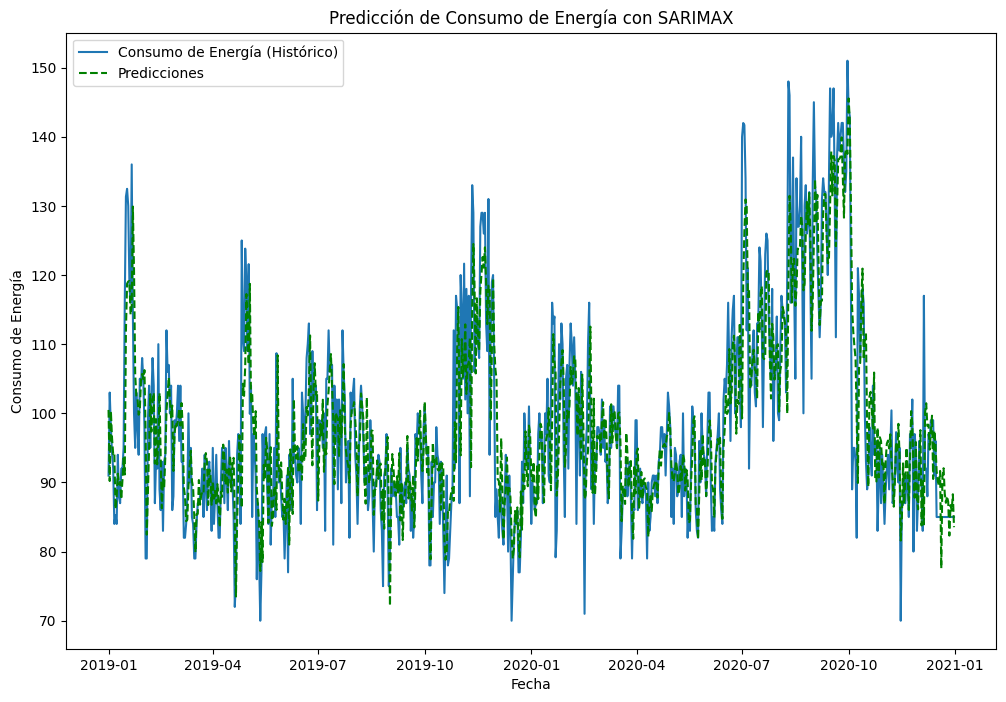

In [528]:

# Graficar
plt.figure(figsize=(12, 8))
plt.plot(daily_max_consumption, label='Consumo de Energía (Histórico)')
plt.plot(pred_mean, color='green', linestyle='--', label='Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Consumo de Energía')
plt.title('Predicción de Consumo de Energía con SARIMAX')
plt.legend()
plt.show()